In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

X=torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [11]:
from torchsummary import summary
summary(net,(1,28,28),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 6, 28, 28]             156
           Sigmoid-2             [1, 6, 28, 28]               0
         AvgPool2d-3             [1, 6, 14, 14]               0
            Conv2d-4            [1, 16, 10, 10]           2,416
           Sigmoid-5            [1, 16, 10, 10]               0
         AvgPool2d-6              [1, 16, 5, 5]               0
           Flatten-7                   [1, 400]               0
            Linear-8                   [1, 120]          48,120
           Sigmoid-9                   [1, 120]               0
           Linear-10                    [1, 84]          10,164
          Sigmoid-11                    [1, 84]               0
           Linear-12                    [1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

loss 0.469, train acc 0.824, test acc 0.819
55356.8 examples/sec on cuda:0


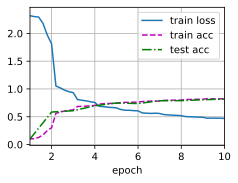

In [5]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)

def evaluate_accuracy_gpu(net,data_iter,device=None):   #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device=next(iter(net.parameters())).device
    metric=d2l.Accumulator(2)   # 正确预测的数量,总预测的数量
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X,list):
                X=[x.to(device) for x in X] # BERT微调所需的
            else:
                X=X.to(device)
            y=y.to(device)
            metric.add(d2l.accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):   #@save
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=['train loss','train acc','test acc'])
    timer,num_batches=d2l.Timer(),len(train_iter)
    for epoch in range(num_epochs):
        metric=d2l.Accumulator(3)   # 训练损失之和,训练准确度之和,样本数
        net.train()
        for i,(X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
            timer.stop()
            train_l=metric[0]/metric[2]
            train_acc=metric[1]/metric[2]
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,(train_l,train_acc,None))
        test_acc=d2l.evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(device)}')

lr,num_epochs=0.9,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

Exercises

使用最大汇聚层

loss 0.404, train acc 0.851, test acc 0.825
61141.9 examples/sec on cuda:0


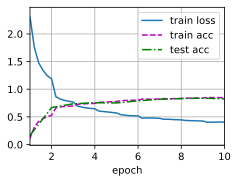

In [7]:
net_maxpool=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

train_ch6(net_maxpool,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

改进LeNet

In [9]:
net_new=nn.Sequential(
    nn.Conv2d(1,10,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(10,20,kernel_size=3),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(20,40,kernel_size=3),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(40*2*2,256),nn.ReLU(),
    nn.Linear(256,128),nn.ReLU(),
    nn.Linear(128,64),nn.ReLU(),
    nn.Linear(64,10)
)

X=torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net_new:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 10, 28, 28])
ReLU output shape:	 torch.Size([1, 10, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 10, 14, 14])
Conv2d output shape:	 torch.Size([1, 20, 12, 12])
ReLU output shape:	 torch.Size([1, 20, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 20, 6, 6])
Conv2d output shape:	 torch.Size([1, 40, 4, 4])
ReLU output shape:	 torch.Size([1, 40, 4, 4])
MaxPool2d output shape:	 torch.Size([1, 40, 2, 2])
Flatten output shape:	 torch.Size([1, 160])
Linear output shape:	 torch.Size([1, 256])
ReLU output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 128])
ReLU output shape:	 torch.Size([1, 128])
Linear output shape:	 torch.Size([1, 64])
ReLU output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 10])


loss 0.161, train acc 0.939, test acc 0.875
45784.9 examples/sec on cuda:0


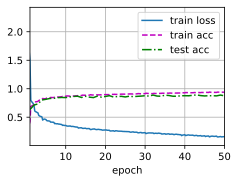

In [18]:
train_ch6(net_new,train_iter,test_iter,num_epochs=50,lr=0.1,device=d2l.try_gpu())

MNIST数据集：手写数字识别

loss 0.105, train acc 0.968, test acc 0.971
62791.4 examples/sec on cuda:0


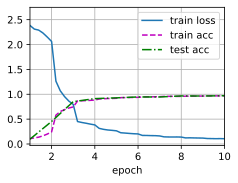

In [50]:
import torchvision
from torchvision import transforms
from torch.utils import data

def load_data_mnist(batch_size,resize=None):
    """下载MNIST数据集，然后将其加载到内存中"""
    trans=[transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans=transforms.Compose(trans)
    mnist_train=torchvision.datasets.MNIST(root="../data",train=True,transform=trans,download=True)
    mnist_test=torchvision.datasets.MNIST(root="../data",train=False,transform=trans,download=True)
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=d2l.get_dataloader_workers()),
            data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=d2l.get_dataloader_workers()))

def init_weights(m):
    if type(m)==nn.Linear or type(m)==nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        
train_iter,test_iter=load_data_mnist(batch_size=batch_size)
net.apply(init_weights)
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

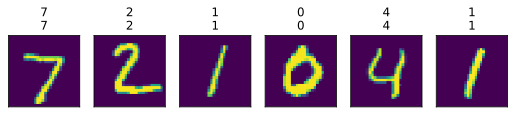

In [65]:
def predict_mnist(net,test_iter,n=6):
    """预测标签"""
    for X,y in test_iter:
        break
    trues=[str(int(i)) for i in y]
    preds=[str(int(i)) for i in net(X.cuda()).argmax(axis=1)]
    titles=[true+'\n'+pred for true,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])

predict_mnist(net,test_iter)

输入经过各层的激活值

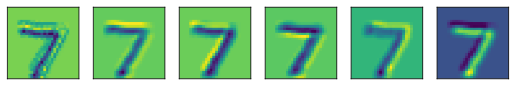

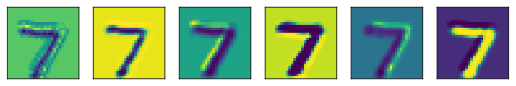

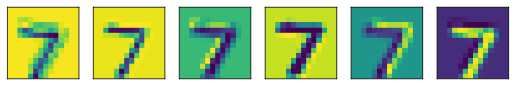

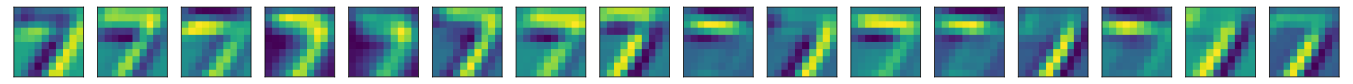

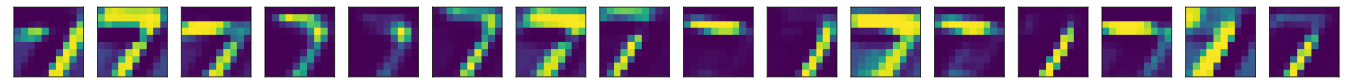

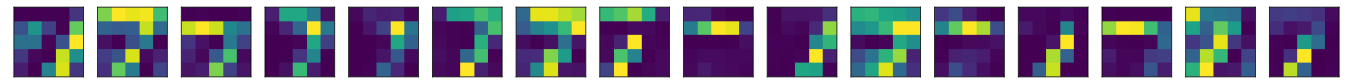

In [95]:
for X,y in test_iter:
    break
for i in range(6):
    d2l.show_images(net[0:i+1]((X[0].cuda())).cpu().detach().numpy(),1,6 if i<3 else 16);
